In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import random

In [2]:
# csvファイルからPandas DataFrameへ読み込み
data = pd.read_csv('sample_2.csv', delimiter=',', low_memory=False, header=None)
data.columns = ['x', 'y']

# 冒頭を表示して確認
data.head()

,x,y
0,0,71859
1,1,74156
2,2,75691
3,3,76325
4,4,75962


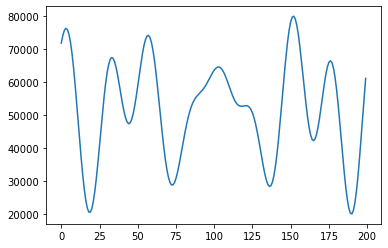

In [3]:
data.y.plot()

In [4]:
# 30日分のデータを１塊とした窓を作る
n_prev = 30
def _load_data(split_data):
    docX, docY = [], []
    for i in range(len(split_data)-n_prev):
        docX.append(split_data.iloc[i:i+n_prev])
        docY.append(split_data.iloc[i+n_prev])
    alsX = np.array(docX)
    alsY = np.array(docY)
    
    return pd.DataFrame(alsX), pd.DataFrame(alsY)

In [5]:
# データを訓練データと検証データに分割する
def split_data(split_num):
    x_train, y_train = _load_data(data.y.iloc[0:split_num])
    x_test, y_test = _load_data(data.y.iloc[split_num-n_prev:split_num+1])

    return x_train, y_train, x_test, y_test

In [6]:
# sklearnで重回帰分析
from sklearn.linear_model import LinearRegression

# モデルを構築する
def model_set(x_train, y_train):
    # モデルを作成する
    model = LinearRegression()
    # 学習
    model.fit(x_train, y_train)

    return model

In [7]:
# 自己回帰モデルを構築し予測を行う
Y_test_pred_lst = np.array([])
for day in range(100,200):
    # データを分割する
    x_train, y_train, x_test, y_test = split_data(day)
    
    # 重回帰分析によるモデルを構築
    model = model_set(x_train, y_train)
    
    # 学習データへの適用結果の誤差の分散を求め、εtを求める
    Y_train_pred_lst = np.array([])
    for i in range(len(x_train)):
        Y_train_pred = model.predict(x_train[i:i+1])
        Y_train_pred_lst = np.append(Y_train_pred_lst, Y_train_pred)
    εt = np.var(y_train.T.values - Y_train_pred_lst) * random.random()
    
    # 自己回帰モデルで予測する
    Y_test_pred = model.predict(x_test) + εt
    
    # 結果を格納
    Y_test_pred_lst = np.append(Y_test_pred_lst, Y_test_pred)

In [8]:
# 正解データ
Y_test_lst = data.y.iloc[100:]

# 検証データへの精度
print('r2: %.3f' % r2_score(Y_test_pred_lst, Y_test_lst))

# ユークリッド距離での誤差
score = np.array([abs(p-t) for p,t in zip(Y_test_pred_lst, Y_test_lst)])
np.sum(score)

r2: 1.000


73.13435353176101

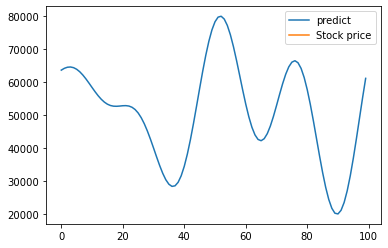

In [9]:
# 実績と比較
dataf =  pd.DataFrame(Y_test_pred_lst)
dataf.columns = ["predict"]
dataf["Stock price"] = Y_test_lst
dataf.plot()